# Spoken Language Classifier

This notebook trains a convolutional neural network to classfify audio files of voice recordings into the languages that were spoken. The dataset I used contained 65.000 files across 176 languages. I found it on TopCoder (https://goo.gl/G5XBJl). I liked the idea behind this problem, because it's very hard for humans to do. It's intersting to see that CNNs perform well on problems where intuition doesn't get you anywhere.

## 1 Imports, Variables and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
import librosa as lr
import shutil
import dask.array as da
import h5py
import glob

from keras.models import Model, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Dropout, Input, BatchNormalization
from keras.optimizers import Nadam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
in_dim = (192,192,1)
out_dim = 176
batch_size = 32
mp3_path = 'data/mp3/'
tr_path = 'data/train/'
va_path = 'data/valid/'
te_path = 'data/test/'
data_size = 66176
tr_size = 52800
va_size = 4576
te_size = 8800

This will convert a single mp3 file to a spectrogram and return the image. The mel-spectrogram is used to get more information in the lower frequencies similar to human hearing. The intensities and the frequencies are then scaled logarithmically. This function will also cut away 5% of the beginning and end of the file. This is to get rid of silence and ensure the same dimensions of each file it outputs. The conversion takes roughly 1sec per minute of audio.

In [3]:
def mp3_to_img(path, height=192, width=192):
    signal, sr = lr.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width*1.1) #this will cut away 5% from start and end
    spec = lr.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = lr.logamplitude(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

Batch convert all mp3-files to spectrogram jpgs. process_audio_with_classes() will use the labels to sort all jpgs in coresponding subfolders. This is useful for the flow_from_directory function in Keras.

In [4]:
def process_audio(in_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    files = glob.glob(in_folder+'*.mp3')
    start = len(in_folder)
    for file in files:
        img = mp3_to_img(file)
        sp.misc.imsave(out_folder + file[start:] + '.jpg', img)
        
def process_audio_with_classes(in_folder, out_folder, labels):
    os.makedirs(out_folder, exist_ok=True)
    for i in range(len(labels['Sample Filename'])):
        file = labels['Sample Filename'][i]
        lang = labels['Language'][i]
        os.makedirs(out_folder + lang, exist_ok=True)
        img = mp3_to_img(in_folder+file)
        sp.misc.imsave(out_folder + lang + '/' + file + '.jpg', img)

Convert a directory of images to a HDF5 file storing the images in an array. The shape of the array will be (img_num, height, width[, channels]).

In [5]:
def jpgs_to_h5(source, target, name):
    da.image.imread(source + '*.jpg').to_hdf5(target, name)

## 2 Preparing the data

The raw data consists of 66176 44,1kHz stereo mp3 file with a length of 10 seconds each. The dataset is perfectly balanced with 376 files per language.

We can visualize this file by converting it to a log-mel-spectrogram.

- the y-axis shows the frequency
- the x-axis shows the time
- the color shows the intensity of a frequency at a given time

The spectrograms gave me headaches at first. Although it's easy to read a spectrogram, it's hard to "intuitively" judge the content of an audio file. My first try of converting them looked totally fine, but I wasn't able to train my network at all. I used a regular spectrogram which I then converted to log scale frequencies. The trouble was that by squeezing the higher frequencies I was pulling apart the lower frequencies. That's the general idea of a log scale and all, but I didn't take into account that the resolution in the lower frequencies would suffer badly. To my luck I wasn't the first person with this problem, so in 1980 a couple of guys came up with the mel-spectrogram which gives more resolution to lower frequencies. After that I also log scaled the intensities of my data points which seemed to help as well.

I started out with a resolution of 224x448 pixels but this took forever on my computer. I applied some asymetrical resizing and noticed that my assumption of reserving more space for the time axis was wrong. Square images seemed to perform best. So, I went ahead and converted everything to 192x192, which didn't hurt the performance all that much.

The "sanity check" of the data turned out to be difficult with this dataset. Apparently you can have 176 different languages without including english, german or french. But all the dutch samples sounded like what dutch people sound like, so I figured it couldn't be that wrong.

Convert the mp3 files to jpgs

In [ ]:
process_audio('data/mp3/', 'data/jpg/')

Covert the folder of images to a compressed container file

In [ ]:
jpgs_to_h5('data/jpg/', 'data/data.h5', 'data')

Shuffle the data and split it into train, valid and test

In [ ]:
y = pd.read_csv('data/train_list.csv')['Language']
y = pd.get_dummies(y)
y = y.reindex_axis(sorted(y.columns), axis=1)
y = y.values
y = da.from_array(y, chunks=1000)
y

In [ ]:
x = h5py.File('data/data.h5')['data']
x = da.from_array(x, chunks=1000)
x

In [ ]:
shfl = np.random.permutation(data_size)

tr_idx = shfl[:tr_size]
va_idx = shfl[tr_size:tr_size+va_size]
te_idx = shfl[tr_size+va_size:]

x[tr_idx].to_hdf5('data/x_tr.h5', 'x_tr')
y[tr_idx].to_hdf5('data/y_tr.h5', 'y_tr')
x[va_idx].to_hdf5('data/x_va.h5', 'x_va')
y[va_idx].to_hdf5('data/y_va.h5', 'y_va')
x[te_idx].to_hdf5('data/x_te.h5', 'x_te')
y[te_idx].to_hdf5('data/y_te.h5', 'y_te')

## 3 Load and process the data

Read the data we've prepared and check its dimensions

In [6]:
x_tr = da.from_array(h5py.File('data/x_tr.h5')['x_tr'], chunks=1000)
y_tr = da.from_array(h5py.File('data/y_tr.h5')['y_tr'], chunks=1000)
print(x_tr.shape, y_tr.shape)

x_va = da.from_array(h5py.File('data/x_va.h5')['x_va'], chunks=1000)
y_va = da.from_array(h5py.File('data/y_va.h5')['y_va'], chunks=1000)
print(x_va.shape, y_va.shape)

x_te = da.from_array(h5py.File('data/x_te.h5')['x_te'], chunks=1000)
y_te = da.from_array(h5py.File('data/y_te.h5')['y_te'], chunks=1000)
print(x_te.shape, y_te.shape)

(52800, 192, 192, 1) (52800, 176)
(4576, 192, 192, 1) (4576, 176)
(8800, 192, 192, 1) (8800, 176)


In [7]:
x_tr /= 255.
x_va /= 255.
x_te /= 255.

Let's check a sample just to be sure

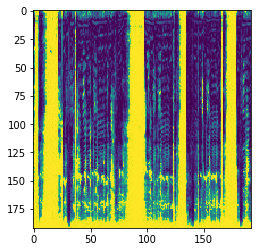

In [8]:
test_img = x_tr[0, :, :, 0]
plt.imshow(test_img)
plt.show()

## 4 Model

I tried roughly 30 different models with focus on newer architectures like residual networks, networks in networks, squeezing and expanding convolutions, but in the end a 5x-Conv-MaxPool worked best. I really wanted to replace the last Dense layers with AveragePooling. They give a little more insight to what's happening in comparison to the "black box"-model that results from dense layers. However it didn't work out as well. I'm guessing this is because spectrograms show a different abstraction of information in comparison to a regular photo showing one object.

In my tests the use of Elu replaced the need for Batch Normalization, which usually improves any model. I didn't include them for performance reasons.

In [9]:
i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation='elu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='elu')(m)
m = Dropout(0.5)(m)
o = Dense(out_dim, activation='softmax')(m)

model = Model(inputs=i, outputs=o)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192, 192, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 192, 16)      160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 24, 24, 64)        0         
__________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-3), metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=2, verbose=1, validation_data=(x_va, y_va))
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=1e-4), metrics=['accuracy'])
model.fit(x_tr, y_tr, epochs=3, verbose=1, validation_data=(x_va, y_va))

In [10]:
model = load_model('speech_v9.h5')

In [11]:
model.evaluate(x_te, y_te)

8800/8800 [==============================] - 182s     

[0.050450170478698882, 0.98795454545454542]